<a href="https://colab.research.google.com/github/IsmailOtukoya/CreditCard-Fraud-Detection-/blob/main/CreditCard_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

index - Unique Identifier for each row

trans_date_trans_time - Transaction DateTime

cc_num - Credit Card Number of Customer

merchant - Merchant Name
category - Category of Merchant

amt - Amount of Transaction

first - First Name of Credit Card Holder

last - Last Name of Credit Card Holder

gender - Gender of Credit Card Holder

street - Street Address of Credit Card Holder

city - City of Credit Card Holder

state - State of Credit Card Holder

zip - Zip of Credit Card Holder

lat - Latitude Location of Credit Card Holder

long - Longitude Location of Credit Card Holder

city_pop - Credit Card Holder's City Population

job - Job of Credit Card Holder

dob - Date of Birth of Credit Card Holder

trans_num - Transaction Number

unix_time - UNIX Time of transaction

merch_lat - Latitude Location of Merchant

merch_long - Longitude Location of Merchant

is_fraud - Fraud Flag <--- Target Class


# **Data Exploration**

Dataset Information:

The dataset contains 35,041 entries and 23 columns.
Column types include int64, float64, and object (likely representing strings).
The "is_fraud" column has one missing value.
First Few Rows:

The first few rows of the dataset provide a glimpse of the data structure and content.
Summary Statistics:

Summary statistics for numerical columns (count, mean, std, min, 25%, 50%, 75%, max).
The mean for the "is_fraud" column suggests a low overall incidence of fraud (mean = 0.010074).
Unique Values in 'is_fraud':

The target variable "is_fraud" is binary, with 0.0 indicating non-fraudulent transactions and 1.0 indicating fraudulent transactions.
Most entries (34,687) are non-fraudulent, while there are 353 instances of fraud.
Missing Values:

There is one missing value in the "is_fraud" column, which needs to be addressed before training the model.

---



---



In [ ]:
import pandas as pd

# Load the dataset
file_path = r"/content/fraudTrain.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

# Display the first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(df.head())

# Summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
print(df.describe())

# Unique values in the target variable "is_fraud"
print("\nUnique values in 'is_fraud':")
print(df['is_fraud'].value_counts())

# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15593 entries, 0 to 15592
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15593 non-null  int64  
 1   trans_date_trans_time  15593 non-null  object 
 2   cc_num                 15593 non-null  int64  
 3   merchant               15593 non-null  object 
 4   category               15593 non-null  object 
 5   amt                    15593 non-null  float64
 6   first                  15593 non-null  object 
 7   last                   15593 non-null  object 
 8   gender                 15593 non-null  object 
 9   street                 15593 non-null  object 
 10  city                   15593 non-null  object 
 11  state                  15593 non-null  object 
 12  zip                    15593 non-null  int64  
 13  lat                    15593 non-null  float64
 14  long                   15593 non-null  f

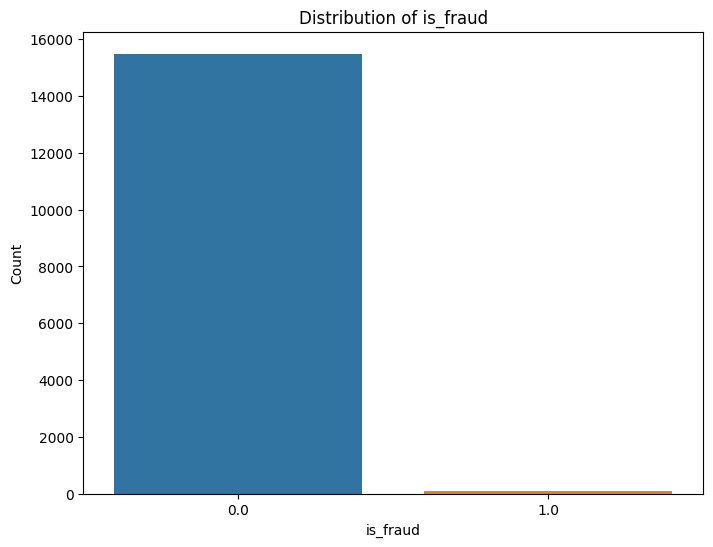

Missing values after dropping: 
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for the distribution of 'is_fraud'
plt.figure(figsize=(8, 6))
sns.countplot(x='is_fraud', data=df)
plt.title('Distribution of is_fraud')
plt.xlabel('is_fraud')
plt.ylabel('Count')
plt.show()

# Drop the row with the missing value in 'is_fraud'
df = df.dropna(subset=['is_fraud'])

# Confirm that the row with missing value is dropped
print("Missing values after dropping: ")
print(df.isnull().sum())


In [ ]:
from datetime import datetime

# Convert 'trans_date_trans_time' and 'dob' columns to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

# Calculate transaction hour and day
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day'] = df['trans_date_trans_time'].dt.day

# Calculate age of the customer based on today's date
current_date = datetime(2023, 12, 19)  # Today's date
df['age'] = (current_date - df['dob']).astype('<m8[Y]')

# Drop the original 'trans_date_trans_time' and 'dob' columns
df = df.drop(['trans_date_trans_time', 'dob'], axis=1)

# Display the updated DataFrame
print(df.head())


   Unnamed: 0            cc_num                            merchant  \
0           0  2703186189652095          fraud_Rippin, Kub and Mann   
1           1      630423337322     fraud_Heller, Gutmann and Zieme   
2           2    38859492057661                fraud_Lind-Buckridge   
3           3  3534093764340240  fraud_Kutch, Hermiston and Farrell   
4           4   375534208663984                 fraud_Keeling-Crist   

        category     amt      first     last gender  \
0       misc_net    4.97   Jennifer    Banks      F   
1    grocery_pos  107.23  Stephanie     Gill      F   
2  entertainment  220.11     Edward  Sanchez      M   
3  gas_transport   45.00     Jeremy    White      M   
4       misc_pos   41.96      Tyler   Garcia      M   

                         street            city  ... city_pop  \
0                561 Perry Cove  Moravian Falls  ...     3495   
1  43039 Riley Greens Suite 393          Orient  ...      149   
2      594 White Dale Suite 530      Malad City

<ipython-input-3-a08246e7877a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
<ipython-input-3-a08246e7877a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dob'] = pd.to_datetime(df['dob'])
<ipython-input-3-a08246e7877a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [ ]:
df_subset = df.head(100)
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut #This would be use to handle timeout gracefully, it will catch the exception and set the location to 'None'

# Function for reverse geocoding
def reverse_geocode(lat, long):
    geolocator = Nominatim(user_agent="reverse_geocode_example", timeout=25)
    try:
        location = geolocator.reverse((lat, long), language='en')
        return location.address if location else None
    except GeocoderTimedOut:
        return None
# Example usage
latitude = 38.542701
longitude = -90.240719

merchant_location = reverse_geocode(latitude, longitude)
print("Merchant Location:", merchant_location)




Merchant Location: Levee Road, Vulcan, East Carondelet, Saint Clair County, Illinois, 62240, United States


In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Create a subset (adjust the number of rows as needed)
#df_subset = df.head(10000)

# Function for reverse geocoding
def reverse_geocode(lat, long):
    geolocator = Nominatim(user_agent="reverse_geocode_example", timeout=25)
    try:
        location = geolocator.reverse((lat, long), language='en')
        return location.address if location else None
    except GeocoderTimedOut:
        return None

# Apply reverse geocoding to the subset
df['merchant_location'] = df.apply(lambda row: reverse_geocode(row['merch_lat'], row['merch_long']), axis=1)

# Display the resulting subset with the new 'merchant_location' column
print(df[['merch_lat', 'merch_long', 'merchant_location']])


In [ ]:
df.head()